In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexTorchCombinator import ConvexTorchCombinator
from convexmtl_torch.model.GraphLaplacianTorchCombinator import GraphLaplacianTorchCombinator
from convexmtl_torch.model.utils import NeuralNetwork

from convexmtl_torch.data.MTLSyntheticDataset import MTLIndependentRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from copy import copy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
max_epochs=100
log_every_n_steps=10
problem = 'independent'

In [28]:
mtlds = MTLIndependentRegression(n_samples_per_task=100)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

ic| tasks: [0, 10, 20]
ic| colors: {0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             10: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
             20: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)}
ic| X_data.shape: (300, 1)


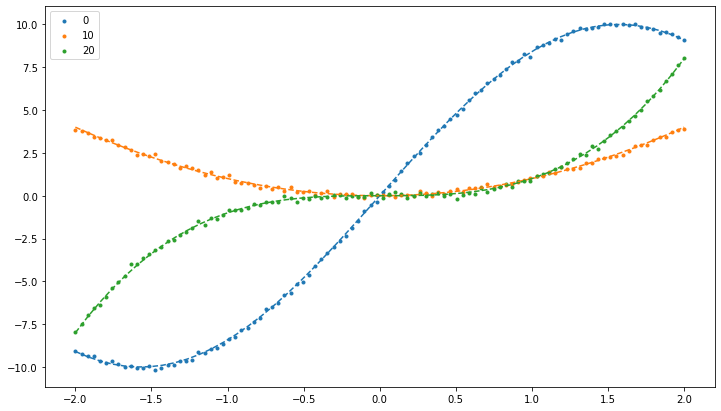

In [29]:
mtlds.plot_data_functions(X, y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [31]:
X_train, t_train = X_train[:,:-1], X_train[:,-1].astype(int)
X_test, t_test = X_test[:,:-1], X_test[:,-1].astype(int)
X_train, t_train, y_train = map(torch.tensor, (X_train, t_train, y_train))
X_train, t_train, y_train = map(lambda obj: obj.float(), [X_train, t_train, y_train])
X_test, t_test, y_test = map(torch.tensor, (X_test, t_test, y_test))
X_test, t_test, y_test = map(lambda obj: obj.float(), [X_test, t_test, y_test])


In [32]:
tasks = np.unique(t_train)
n_tasks = len(tasks)

In [33]:
# train_ds = TensorDataset(X_train, t_train, y_train)
train_ds = TensorDataset(X_train, t_train, y_train)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)



## ConvexMTL Torch

In [34]:
epochs=100

In [35]:
model = ConvexTorchCombinator(n_features=1, n_output=1, n_channel=1, tasks=tasks, specific_lambda=False)
# model = NeuralNetwork(n_features=1)

In [36]:
trainer = Trainer(max_epochs=max_epochs, log_every_n_steps=log_every_n_steps, default_root_dir='convex_{}_logs'.format(problem))

trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params
-------------------------------------------------
0 | common_module_ | NeuralNetwork | 8.5 K 
-------------------------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: T

Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 35.13it/s, loss=0.0287, v_num=3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 31.45it/s, loss=0.0287, v_num=3]


In [37]:
# pred = model(X_test, t_test)
pred = model(X_test, t_test)

In [38]:
pred_numpy = pred.detach().numpy()
pred_numpy.shape

(99, 1)

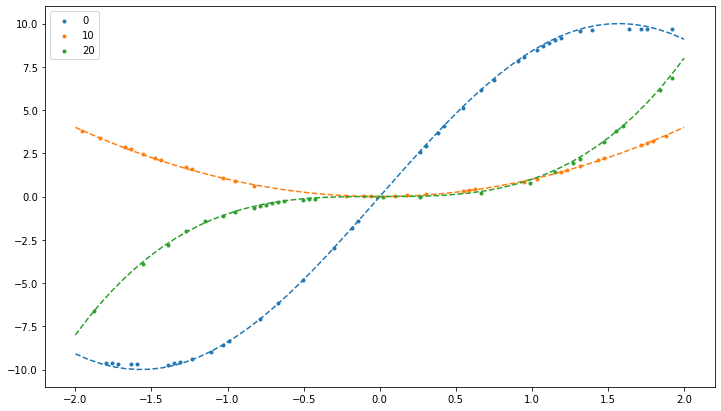

In [39]:
mtlds.plot_data_functions(X_test_numpy, pred_numpy)

In [40]:
model.get_lamb()

ic| self.lamb: Parameter containing:
               tensor([-1.0805], requires_grad=True)


array([0.25340256], dtype=float32)

## GraphLaplacian Torch

In [16]:
max_epochs=100

In [17]:
model = GraphLaplacianTorchCombinator(n_features=1, n_output=1, n_channel=1, tasks=tasks, nu=0.1, mu=0.1, adj_lr=1e-1)
# model = NeuralNetwork(n_features=1)

In [18]:
trainer = Trainer(max_epochs=max_epochs, log_every_n_steps=log_every_n_steps, default_root_dir='gl_{}_logs'.format(problem))

trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type                   | Params
----------------------------------------------------------
0 | common_module_ | NeuralNetworkFeatLearn | 8.4 K 
----------------------------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.034     Total estimated model params size (MB)
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/tra

Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 44.90it/s, loss=21.2, v_num=1]

ic| self.current_epoch: 0


Epoch 50: 100%|██████████| 7/7 [00:00<00:00, 53.71it/s, loss=0.785, v_num=1]

ic| self.current_epoch: 50


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 54.17it/s, loss=-0.0284, v_num=1] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 46.80it/s, loss=-0.0284, v_num=1]


In [19]:
# pred = model(X_test, t_test)
pred = model(X_test, t_test)

In [20]:
pred_numpy = pred.detach().numpy()
pred_numpy.shape

(99, 1)

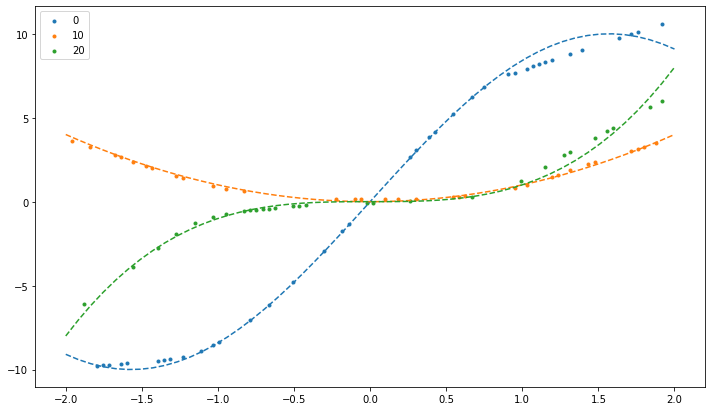

In [21]:
mtlds.plot_data_functions(X_test_numpy, pred_numpy)

In [22]:
adjMatrix = model.get_adjMatrix()

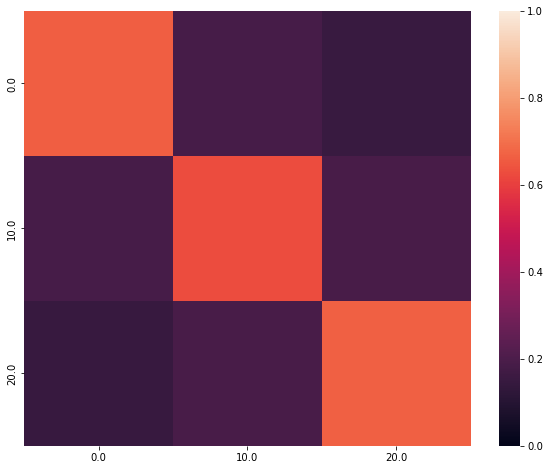

In [23]:
fig = model.get_fig_adjMatrix()
plt.show()

In [43]:
%reload_ext tensorboard
%tensorboard --logdir=gl_independent_logs/